In [1]:
import os
import glob
import random
import obspy
import torch

from obspy import Stream
from obspy import read
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth
from obspy.signal.trigger import classic_sta_lta

import numpy as np 
import scipy.signal as signal
import matplotlib.pyplot as plt 

In [2]:
def scale_amplitude(data, rate):
    'Scale amplitude or waveforms'
    
    tmp = np.random.uniform(0, 1)
    if tmp < rate:
        data *= np.random.uniform(1, 3)
    elif tmp < 2 * rate:
        data /= np.random.uniform(1, 3)
    return data

In [3]:
def shift_event(data, maxshift, rate, start, halfdim): 
    'Randomly rotate the array to shift the event location'
    
    if np.random.uniform(0, 1) < rate:
        start += int(np.random.uniform(-maxshift, maxshift))             
    return data[:, start-halfdim:start + halfdim]

In [4]:
def get_wave_arrival(input_Stream):

    # 選取第一個Trace對象
    tr = input_Stream[0]

    # 測站的緯度和經度
    station_latitude = tr.stats.sac.stla
    station_longitude = tr.stats.sac.stlo


    # 地震源的緯度和經度
    event_latitude = tr.stats.sac.evla
    event_longitude = evlo = tr.stats.sac.evlo


    # 使用 ObsPy 的 gps2dist_azimuth 函數來計算距離
    distance_m, azimuth1, azimuth2 = gps2dist_azimuth(station_latitude, station_longitude, event_latitude, event_longitude)
    distance_in_km = distance_m / 1000

    # 將距離從公尺轉換為地震中心距離（以度為單位）
    distance_in_degrees = distance_m / 1000 / 111.195


    # 取得地震源的深度
    depth_in_km = tr.stats.sac.evdp

    # 總距離是地震中心距離與地震深度的和
    total_distance_in_km = distance_in_km + depth_in_km

    # 假定的P波和S波速度
    p_wave_velocity = 6  # km/sec
    s_wave_velocity = 3.5  # km/sec

    # 使用模型來計算抵達時間
    model = TauPyModel(model = "iasp91")
    model = TauPyModel(model = "ak135")
    arrivals = model.get_travel_times(source_depth_in_km = depth_in_km, distance_in_degree = distance_in_degrees)

    # 尋找P波和S波的抵達時間
    P_arrival_time = None
    S_arrival_time = None
    for arrival in arrivals:
        if arrival.name == 'Pn':
            P_arrival_time = arrival.time
        elif arrival.name == 'Sn':
            S_arrival_time = arrival.time
        elif arrival.name == 'P':
            P_arrival_time = arrival.time
        elif arrival.name == 'S':
            S_arrival_time = arrival.time

    # 如果模型無法提供P波或S波的抵達時間，則使用簡單的估計方法
    if P_arrival_time is None:
        # print('simple estimation')
        P_arrival_time = total_distance_in_km / p_wave_velocity

    if S_arrival_time is None:
        # print('simple estimation')
        S_arrival_time = total_distance_in_km / s_wave_velocity

    # print('Estimated P wave arrival time: ', P_arrival_time, 'seconds')
    # print('Estimated S wave arrival time: ', S_arrival_time, 'seconds')

    P_arrival_sample = P_arrival_time * 100
    S_arrival_sample = S_arrival_time * 100

    P_arrival_sample = int(P_arrival_sample)
    S_arrival_sample = int(S_arrival_sample)

    return P_arrival_sample, S_arrival_sample

In [5]:
def get_trigger_sample(input_Stream, p_start_abs, s_start_abs, sta_window = 1, lta_window = 5, threshold = 3.01):


    p_max_abs = p_start_abs
    s_max_abs = s_start_abs

    p_wave_window = 12
    s_wave_window = 12

    for i in range(3):
        tr = input_Stream[i]

        cft = classic_sta_lta(tr.data, int(sta_window * tr.stats.sampling_rate), int(lta_window * tr.stats.sampling_rate))
        
        p_trigger_samples_list = np.where((cft[p_start_abs:p_start_abs + p_wave_window * 100] > threshold))[0]
        s_trigger_samples_list = np.where((cft[s_start_abs:s_start_abs + s_wave_window * 100] > threshold))[0]
        
        if len(p_trigger_samples_list) > 0:
            p_max_sta_lta_sample = p_trigger_samples_list[np.argmax(cft[p_start_abs + p_trigger_samples_list])]
            p_max_abs = max(p_max_abs, p_start_abs + p_max_sta_lta_sample)
        
        if len(s_trigger_samples_list) > 0:
            s_max_sta_lta_sample = s_trigger_samples_list[np.argmax(cft[s_start_abs + s_trigger_samples_list])]
            s_max_abs = max(s_max_abs, s_start_abs + s_max_sta_lta_sample)

    return p_max_abs, s_max_abs

In [6]:
def process_obspy_stream(input_Stream):

    tr = input_Stream[0]


    fsin = 100.0
    fsout = 40.0
    wlen = 2.0
    alpha = 0.05
    freq = 0.5
    maxshift = 80
    shift_event_r = 0.995
    # shift_event_r = 0.0
    scale_amplitude_r = 0.3
    # scale_amplitude_r = 0.0

    dim = int(wlen * fsout)
    indim = int(fsin * wlen) // 2 


    # Apply Filter to Stream
    input_Stream.detrend(type = "linear")
    input_Stream.taper(alpha)
    input_Stream.filter(type = "highpass", freq = freq)

    # Get the wave arrivals
    p_start_relative, s_start_relative = get_wave_arrival(input_Stream)
    
    trigger_time = tr.stats.sac.b * -1
    trigger_sample = trigger_time * 100
    trigger_sample = int(trigger_sample)

    p_start_abs = trigger_sample + p_start_relative # +  6 * 100
    s_start_abs = trigger_sample + s_start_relative + 12 * 100


    # Get the maximum amplitude of waves
    p_max_abs, s_max_abs = get_trigger_sample(input_Stream, p_start_abs, s_start_abs)

    # Split the data
    data = np.vstack([input_Stream[ii].data for ii in range(len(input_Stream))])
    data1 = shift_event(data, maxshift, shift_event_r, p_max_abs, indim)
    data2 = shift_event(data, maxshift, shift_event_r, s_max_abs, indim)

    # Resample data
    data1 = signal.resample(data1, dim, axis = -1)
    data2 = signal.resample(data2, dim, axis = -1)

    # Scale data amplitude
    if scale_amplitude_r:
        data1 = scale_amplitude(data1, scale_amplitude_r)
        data2 = scale_amplitude(data2, scale_amplitude_r)

    # Transpose data
    data1 = data1.transpose()
    data2 = data2.transpose()

    return data1, data2

In [7]:
RCEC = ['5AF48', '5AE11', '5ADF9', '5AE28', '5AF0F', '5AE83', '5AEBA', '5AFE5', '5AE1C']
IES = ['5AE21', '5AE99', '5AE73', '5AF8A', '5AFA8', '5AEE6']
TAIPEI = ['Taipei101']

station_list = RCEC + IES

stream_list = []
QSIS_train_data_X = np.array([])
QSIS_train_data_list = []

minimum_pga = 2.0

In [8]:
file_name_part = 'HLX'

all = 0
useable = 0

for datadir in station_list:

    datadir = os.path.join('./data_QSIS_Event', datadir)

    sac_files_X = glob.glob(f'{datadir}/*{file_name_part}*.sac')
    sac_files_Y = [s.replace('X', 'Y') for s in sac_files_X]
    sac_files_Z = [s.replace('X', 'Z') for s in sac_files_X]


    for i in range(len(sac_files_X)):
        stream = Stream()

        stream_x = read(sac_files_X[i])
        stream_x[0].data = stream_x[0].data * 0.01
        stream += stream_x

        stream_y = read(sac_files_Y[i])
        stream_y[0].data = stream_y[0].data * 0.01
        stream += stream_y

        stream_z = read(sac_files_Z[i])
        stream_z[0].data = stream_z[0].data * 0.01
        stream += stream_z
        
        trace_x = stream_x[0]
        trace_y = stream_y[0]
        trace_z = stream_z[0]
        

        data_len_X = len(stream[0].data)
        data_len_Y = len(stream[1].data)
        data_len_Z = len(stream[2].data)
        include_stream = False
        include_stream = data_len_X == data_len_Y and data_len_Y == data_len_Z and data_len_Z == data_len_X
        include_stream = include_stream and data_len_X >= 40000


        if include_stream:
            all = all + 1
            pga_xyz = np.sqrt(trace_x.data**2 + trace_y.data**2 + trace_z.data**2)
            pga_total = max(pga_xyz)
            pga_total = pga_total * 100

            print("Total PGA (gal): ", pga_total)
            if pga_total >= minimum_pga:
                useable = useable + 1

                stream_list.append(stream)



        if include_stream:
            # stream_list.append(stream)
            pass


print(useable)
print(all)

Total PGA (gal):  3.9983242750167847
Total PGA (gal):  1.2785506434738636
Total PGA (gal):  1.4058752916753292
Total PGA (gal):  1.5941979363560677
Total PGA (gal):  5.7326339185237885
Total PGA (gal):  1.3646799139678478
Total PGA (gal):  1.2097636237740517
Total PGA (gal):  1.211391855031252
Total PGA (gal):  1.4265851117670536
Total PGA (gal):  1.3370213098824024
Total PGA (gal):  1.2910623103380203
Total PGA (gal):  1.20882298797369
Total PGA (gal):  1.2935636565089226
Total PGA (gal):  1.2279185466468334
Total PGA (gal):  1.276502013206482
Total PGA (gal):  1.2649906799197197
Total PGA (gal):  1.3406062498688698
Total PGA (gal):  1.375001110136509
Total PGA (gal):  1.2150573544204235
Total PGA (gal):  1.3145283795893192
Total PGA (gal):  1.3043510727584362
Total PGA (gal):  1.4431956224143505
Total PGA (gal):  1.229164283722639
Total PGA (gal):  1.324150525033474
Total PGA (gal):  1.4167769812047482
Total PGA (gal):  1.6375711187720299
Total PGA (gal):  1.2676977552473545
Total PG

In [9]:
file_name_part = 'HNX'

all = 0
useable = 0

for datadir in TAIPEI:

    datadir = os.path.join('./data_QSIS_Event', datadir)

    sac_files_X = glob.glob(f'{datadir}/*{file_name_part}*.sac')
    sac_files_Y = [s.replace('X', 'Y') for s in sac_files_X]
    sac_files_Z = [s.replace('X', 'Z') for s in sac_files_X]


    for i in range(len(sac_files_X)):
        stream = Stream()

        stream_x = read(sac_files_X[i])
        stream_x[0].data = stream_x[0].data * 0.01
        stream += stream_x

        stream_y = read(sac_files_Y[i])
        stream_y[0].data = stream_y[0].data * 0.01
        stream += stream_y

        stream_z = read(sac_files_Z[i])
        stream_z[0].data = stream_z[0].data * 0.01
        stream += stream_z
        
        trace_x = stream_x[0]
        trace_y = stream_y[0]
        trace_z = stream_z[0]

        trace_y.trim(trace_x.stats.starttime, trace_x.stats.endtime)
        trace_z.trim(trace_x.stats.starttime, trace_x.stats.endtime)

        # pga_xyz = np.sqrt(trace_x.data**2 + trace_y.data**2 + trace_z.data**2)

        # pga_total_square = max(pga_xyz)
        # pga_total = np.sqrt(pga_total_square) * 100

        # print("Total PGA: ", pga_total)


        data_len_X = len(stream[0].data)
        data_len_Y = len(stream[1].data)
        data_len_Z = len(stream[2].data)
        include_stream = False
        include_stream = data_len_X == data_len_Y and data_len_Y == data_len_Z and data_len_Z == data_len_X
        include_stream = include_stream and data_len_X >= 40000


        if include_stream:
            all = all + 1
            pga_xyz = np.sqrt(trace_x.data**2 + trace_y.data**2 + trace_z.data**2)
            pga_total = max(pga_xyz)
            pga_total = pga_total * 100

            print("Total PGA (gal): ", pga_total)
            if pga_total >= minimum_pga:
                useable = useable + 1

                
                stream_list.append(stream)


            

        if include_stream:
            # stream_list.append(stream)
            pass

print(useable)
print(all)

Total PGA (gal):  2.496848627924919
Total PGA (gal):  2.6209386065602303
Total PGA (gal):  2.5482583791017532
Total PGA (gal):  1.144958008080721
Total PGA (gal):  1.1787768453359604
Total PGA (gal):  1.3647917658090591
Total PGA (gal):  1.9140984863042831
Total PGA (gal):  1.4214866794645786
Total PGA (gal):  1.2163996696472168
Total PGA (gal):  1.1863941326737404
Total PGA (gal):  1.4163991436362267
Total PGA (gal):  1.1460179463028908
Total PGA (gal):  1.227311696857214
Total PGA (gal):  1.9569307565689087
Total PGA (gal):  1.3746388256549835
Total PGA (gal):  1.2988773174583912
Total PGA (gal):  1.1310665868222713
Total PGA (gal):  1.204537134617567
Total PGA (gal):  1.334681548178196
Total PGA (gal):  1.1173943988978863
Total PGA (gal):  1.3345464132726192
Total PGA (gal):  1.2854326516389847
Total PGA (gal):  1.392660103738308
Total PGA (gal):  1.6864437609910965
Total PGA (gal):  1.1319348588585854
Total PGA (gal):  1.065942645072937
Total PGA (gal):  1.4948859810829163
Total PG

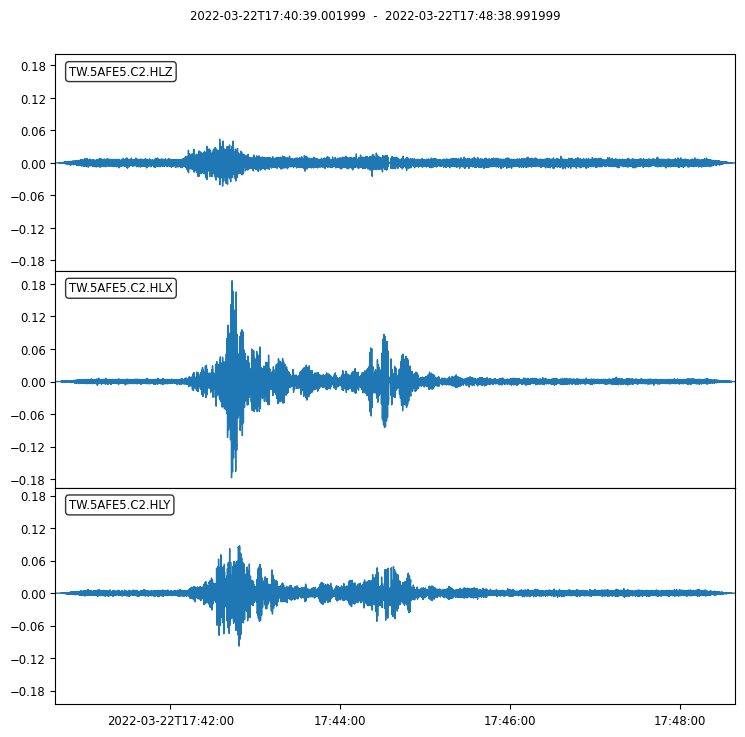

3 Trace(s) in Stream:
TW.5AFE5.C2.HLX | 2022-03-22T17:40:39.001999Z - 2022-03-22T17:48:38.991999Z | 100.0 Hz, 48000 samples
TW.5AFE5.C2.HLY | 2022-03-22T17:40:39.001999Z - 2022-03-22T17:48:38.991999Z | 100.0 Hz, 48000 samples
TW.5AFE5.C2.HLZ | 2022-03-22T17:40:39.001999Z - 2022-03-22T17:48:38.991999Z | 100.0 Hz, 48000 samples


In [10]:
index = 1008
index = random.randint(0, len(stream_list))
# index = 94
# index = 1008

rand_stream = stream_list[index]

alpha = 0.05
freq = 0.5

rand_stream.detrend(type = "linear")
rand_stream.taper(alpha)
rand_stream.filter(type = "highpass", freq = freq)

rand_stream.plot(color = 'C0')
rand_stream.plot(color = 'C0', outfile = './event_noise/rand_stream_event.pdf')

station_name = rand_stream[0].stats.location
instrument_name = rand_stream[0].stats.station
station_info = station_name + ' ' + instrument_name + ' '

print(rand_stream)

In [18]:
print(index)

142


In [19]:
rand_stream
tr = rand_stream[0]
aa  = tr.stats.sac.b * -1

print(aa)

120.49800109863281


In [11]:
freq_min = 0   # Minimum frequency in Hz
freq_max = 6  # Maximum frequency in Hz

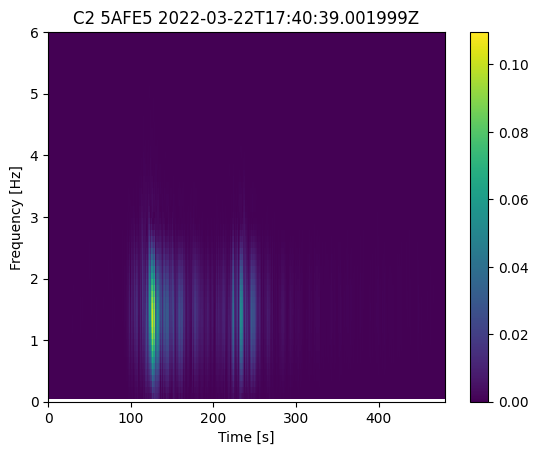

In [12]:
for tr in rand_stream:
    tr.filter('bandpass', freqmin = 1.0, freqmax = 3.0)

rand_stream_spectrogram_ax = plt.axes()
rand_stream[0].spectrogram(log = False, axes = rand_stream_spectrogram_ax, show = False)
rand_stream_spectrogram_ax.set_title(station_info + str(rand_stream[0].stats.starttime))
# rand_stream_spectrogram_ax.set_xlim(xmin = 0, xmax = 200)
rand_stream_spectrogram_ax.set_ylim(ymin = freq_min, ymax = freq_max)

mappable = rand_stream_spectrogram_ax.images[0]
plt.colorbar(mappable = mappable, ax = rand_stream_spectrogram_ax)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.savefig('./event_noise/rand_stream_event_Spectrogram.pdf', dpi = 300)
plt.show()

In [13]:
for i in range(len(stream_list)):
    # print(stream_list[i])
    p_data, s_data = process_obspy_stream(stream_list[i])
    QSIS_train_data_list.append(p_data)
    QSIS_train_data_list.append(s_data)

In [14]:
QSIS_train_data_X = np.stack(QSIS_train_data_list)
QSIS_train_data_X = np.expand_dims(QSIS_train_data_X, axis = -1)

In [15]:
initial_array = np.array([[1., 0., 0.], [0., 1., 0.]])
QSIS_train_data_Y = np.tile(initial_array, (len(stream_list), 1))

print(QSIS_train_data_X.shape)
print(QSIS_train_data_Y.shape)


(964, 80, 3, 1)
(964, 3)


In [16]:
torch.save({'Xevent': QSIS_train_data_X, 'Yevent': QSIS_train_data_Y}, './data_QSIS_pth/event.pth')

In [17]:
datadir = './data_QSIS_pth'

train_data_path = os.path.join(datadir, 'event.pth')
train_data = torch.load(train_data_path)
Xevent = train_data['Xevent']
Yevent = train_data['Yevent']

print(Xevent.shape)
print(Yevent.shape)

(964, 80, 3, 1)
(964, 3)
